In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mj04ifeg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mj04ifeg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=351cf0ad95382d5b4ae3337f54e8d53f9b52bc0826fc71a071fc27ed0309294a
  Stored in directory: /tmp/pip-ephem-wheel-cache-at0mikts/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 9.9 MB/s eta 0:00:00


In [5]:
!pip install pydantic==1.10.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.1
    Uninstalling pydantic-2.6.1:
      Successfully uninstalled pydantic-2.6.1


In [6]:
!mkdir /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/DentalPanoramicXrays.zip /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/Masks.zip /content/data

(1024, 1024, 3)
(1300, 3100, 3)


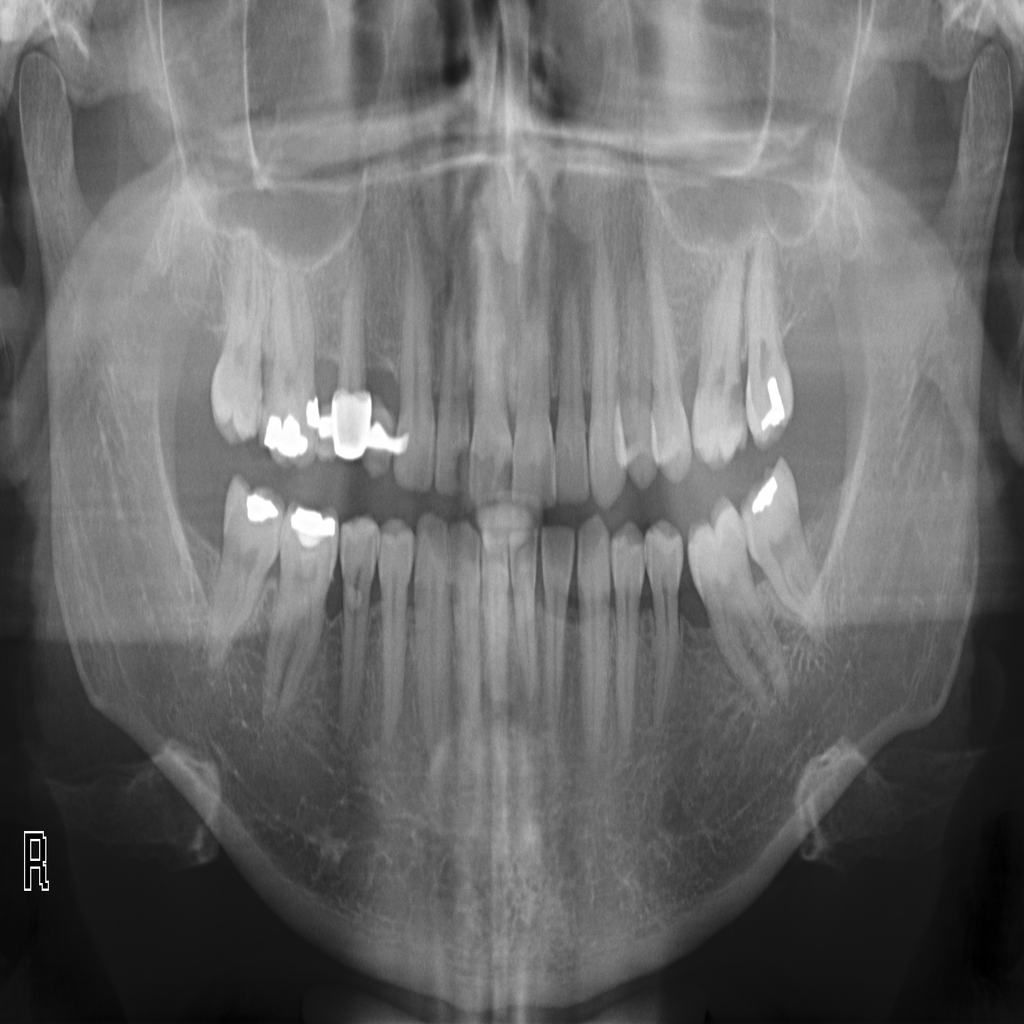

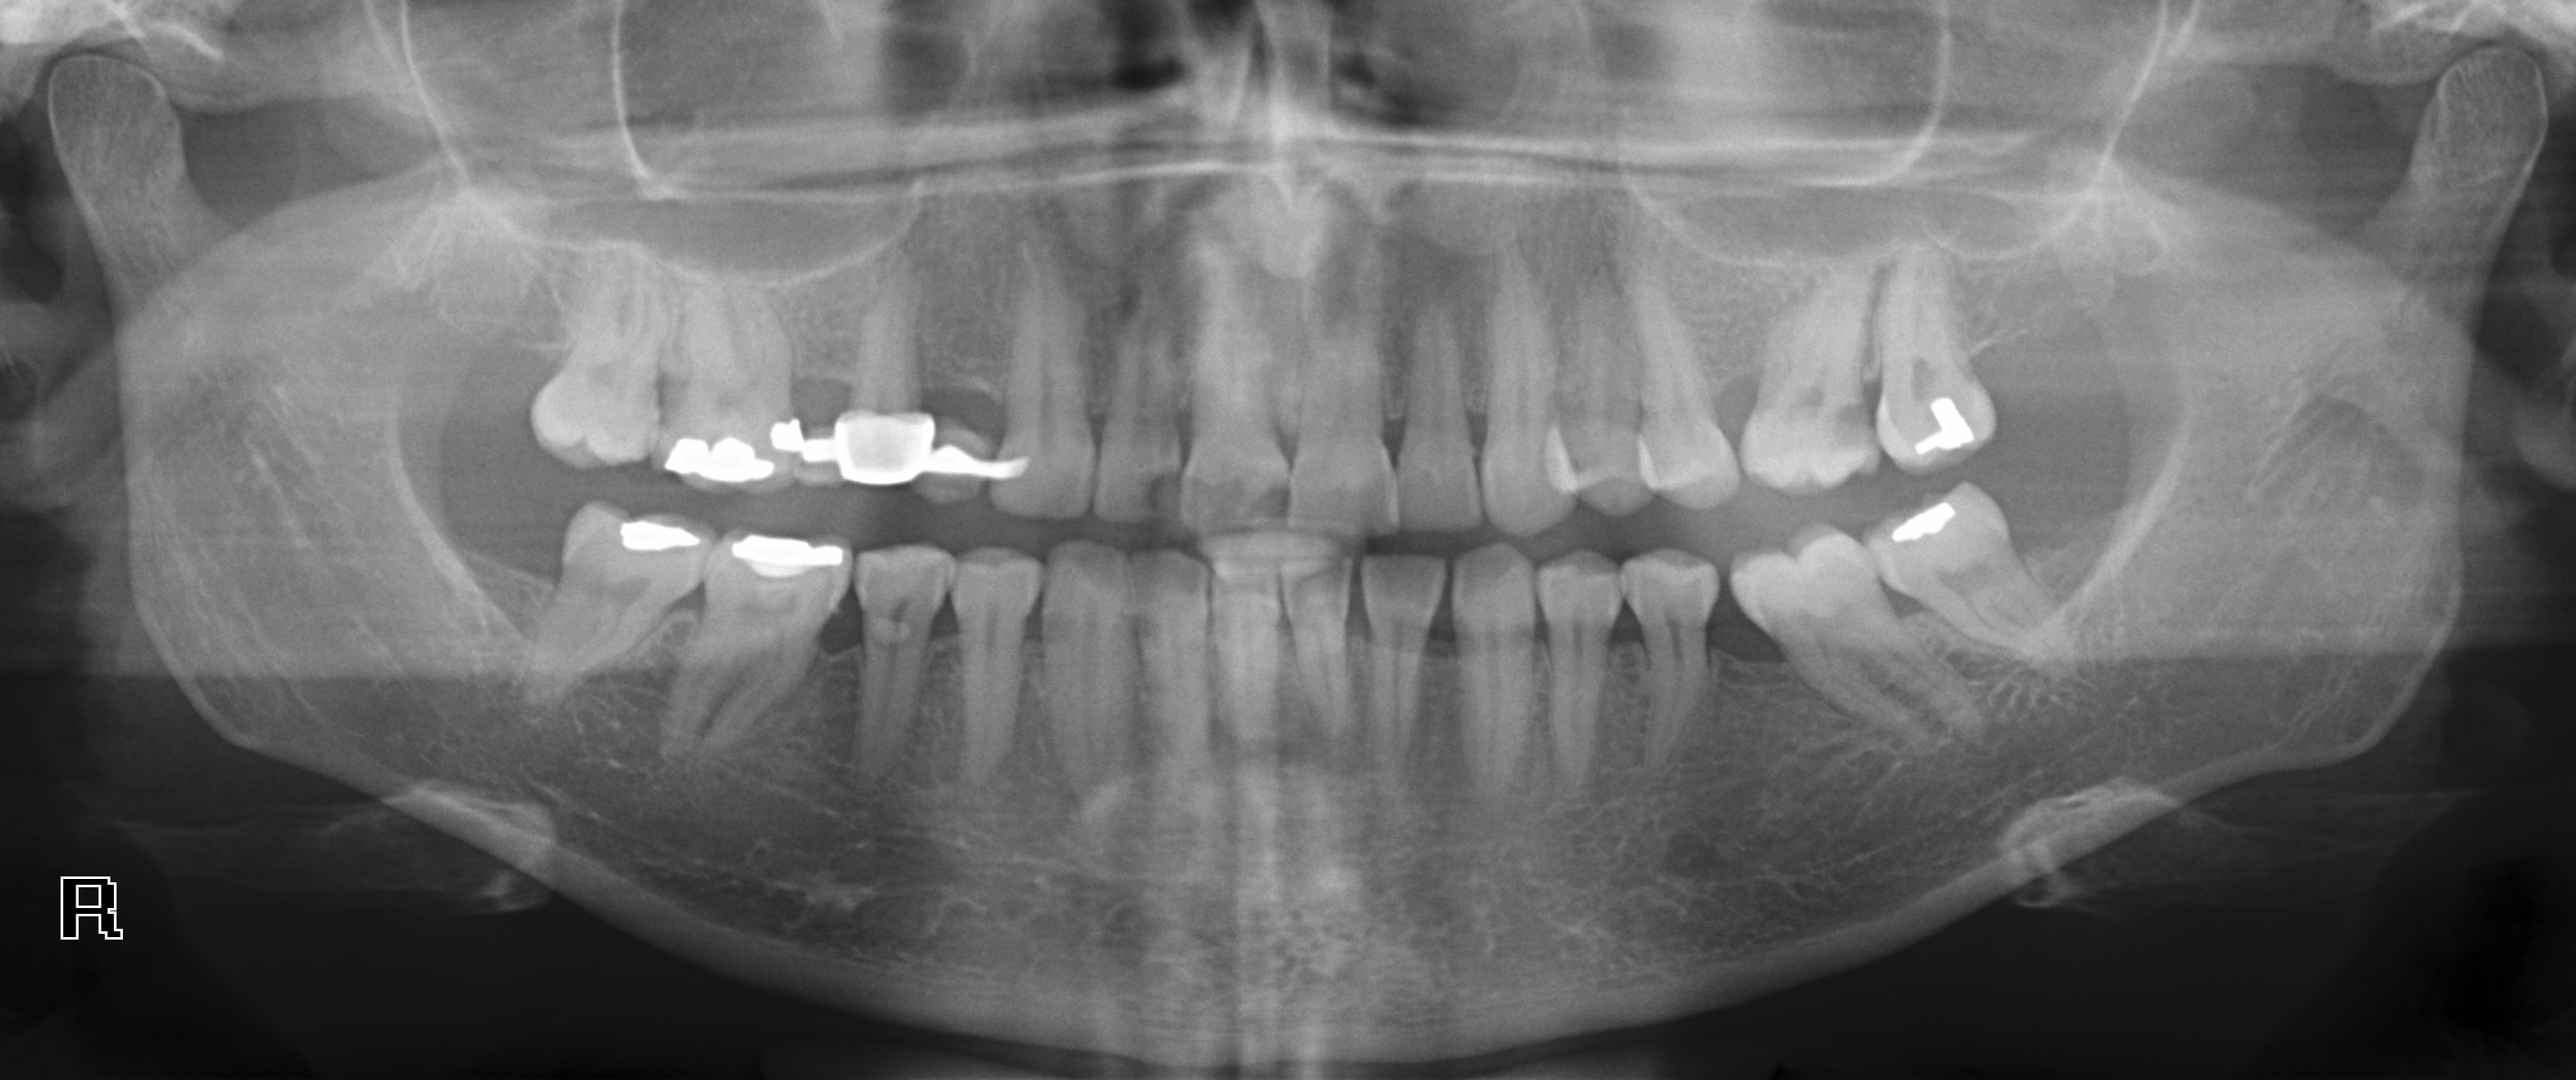

In [53]:
from ast import Pass
import cv2
import numpy as np
import os
import torch
from google.colab.patches import cv2_imshow
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted

def convert_to_three_channel(img):
  if len(img.shape) <= 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

  return img

def convert_to_one_channel(img):
  if len(img.shape) > 2:
    img = img[:,:,0]
  return img

def extract_image_paths(path, zip_name, folder_name, save_path):
  full_path = os.path.join(path, zip_name)
  ZipFile(full_path).extractall(save_path)
  unzipped_path = os.path.join(path, folder_name)
  dirs=natsorted(os.listdir(unzipped_path))
  return dirs

def load_images(resize_shape, path, zip_name, folder_name, save_path, convert_function):

    dirs = extract_image_paths(path, zip_name, folder_name, save_path)

    images = []

    for i in range(len(dirs)):
        img=Image.open(os.path.join(path, folder_name, dirs[i]))
        img=img.resize((resize_shape), Image.LANCZOS )

        img = convert_function(np.asarray(img))
        images.append(img)

    images = np.array(images)
    return images

def load_yolo_images(path, resize_shape):
  image_names = natsorted(os.listdir(path))
  images=[]

  for image_name in image_names:
    img = Image.open(os.path.join(path, image_name))
    if len(images)>0:
      img = img.resize(resize_shape, Image.LANCZOS)

    img = convert_to_three_channel(np.asarray(img))

    img = np.array(img)
    images.append(img)

  images = np.array(images)
  return images



PATH = "/content/data/"
X = load_images((1024, 1024), PATH, "DentalPanoramicXrays.zip",'Images/', "/content/data", convert_to_three_channel)
Y = load_images((1024, 1024), PATH, "Masks.zip", "Masks/", "/content/data/Masks", convert_to_one_channel)
X_yolo = load_yolo_images("/content/data/Images",(3100,1300))

x_train = X[:88]
x_val = X[88:]
y_train = Y[:88]
y_val = Y[88:]
x_train_yolo = X_yolo[:88]
x_val_yolo = X_yolo[88:]

print(x_train[3].shape)
print(x_train_yolo[3].shape)
cv2_imshow(x_train[3])
cv2_imshow(x_train_yolo[3])






In [24]:
def get_fixed_coordinates(box, image):

  x_center = box[0].numpy()
  y_center = box[1].numpy()
  width = box[2].numpy()
  height = box[3].numpy()

  x_center *= image.shape[1]
  y_center *= image.shape[0]
  width *= image.shape[1]
  height *= image.shape[0]

  x1 = int(x_center - width / 2)
  y1 = int(y_center - height / 2)
  x2 = int(x_center + width / 2)
  y2 = int(y_center + height / 2)

  return x1, y1, x2, y2


In [91]:
from ultralytics import YOLO
from torch.nn.functional import threshold, normalize
from tqdm import tqdm
import random
import gc
import torch
from segment_anything import sam_model_registry

sam_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters())
loss_fn = torch.nn.MSELoss()

gc.collect()
torch.cuda.empty_cache()

yolo_model = YOLO("/content/drive/MyDrive/DentalImages/TrainingCheckpoints/best_yolov8.pt")
EPOCHS = 100
MODEL_SAVE_PATH = '/content/SAM'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam_model.to(device)
yolo_model.to(device)

#Training loop

for _ in tqdm(range(EPOCHS)):
  random_select = random.randint(0,87)

  #The weird indexing is meant to add the batch dimension
  image = x_train[random_select:random_select+1].copy()
  yolo_image = x_train_yolo[random_select].copy()
  gt_mask = y_train[random_select:random_select+1].copy()

  image = image.astype(np.float32)
  image = np.reshape(image, (1,3,1024,1024))
  image /= 255.0
  image = torch.from_numpy(image)

  image = image.to(device)


  with torch.no_grad():
    image_embedding = sam_model.image_encoder(image)
    results = yolo_model.predict(yolo_image)

    boxes = results[0].boxes.xywhn
    boxes = torch.Tensor.cpu(boxes)
    box_list = []
    for box in boxes:
      x1, y1, x2, y2 = get_fixed_coordinates(box,image)
      box_list.append([x1, y1, x2, y2])
    if len(box_list) == 0:
      continue
    box_tensor = torch.tensor(box_list)

    box_tensor = box_tensor.to(device)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
              points=None,
              boxes=box_tensor,
              masks=None,
          )

  low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
  )



  upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024,1024),(1024,1024)).to("cpu")

  binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to("cpu")
  # print("Mask shape",gt_mask.shape,"original_shape",image.shape,"yolo_shape", yolo_image.shape)
  gt_mask = np.reshape(gt_mask,(1024,1024))


  # print("GENERATED MASK", binary_mask.shape)
  # cv2_imshow((binary_mask[0,0,:,:].detach().numpy()*255).astype(np.uint8))
  gt_mask = gt_mask.astype(np.float32)
  gt_mask /= 255.0
  # print("Max",np.max(binary_mask[10,0,:,:].detach().numpy()))
  gt_mask = np.stack([gt_mask]*binary_mask.shape[0], axis=0)
  gt_mask = torch.from_numpy(np.reshape(gt_mask,(binary_mask.shape[0],1,1024,1024)))
  # print("GT Mask", gt_mask.shape)
  # cv2_imshow((gt_mask[4,0,:,:].numpy()*255).astype(np.uint8))

  loss = loss_fn(binary_mask, gt_mask)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print("Loss:",loss.item())
torch.save(sam_model, MODEL_SAVE_PATH)

  0%|          | 0/100 [00:00<?, ?it/s]


0: 288x640 25 tooths, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


  1%|          | 1/100 [00:05<09:08,  5.54s/it]

Loss: 0.15070320665836334

0: 288x640 29 tooths, 14.9ms
Speed: 13.4ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


  2%|▏         | 2/100 [00:11<09:34,  5.86s/it]

Loss: 0.19019395112991333

0: 288x640 23 tooths, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


  3%|▎         | 3/100 [00:16<08:30,  5.26s/it]

Loss: 0.16490930318832397

0: 288x640 31 tooths, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


  4%|▍         | 4/100 [00:23<10:01,  6.26s/it]

Loss: 0.2304379791021347

0: 288x640 32 tooths, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


  5%|▌         | 5/100 [00:30<10:10,  6.43s/it]

Loss: 0.2468482106924057

0: 288x640 32 tooths, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


  6%|▌         | 6/100 [00:38<10:34,  6.75s/it]

Loss: 0.25795239210128784

0: 288x640 23 tooths, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


  7%|▋         | 7/100 [00:42<09:23,  6.06s/it]

Loss: 0.1824536919593811

0: 288x640 27 tooths, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


  8%|▊         | 8/100 [00:49<09:38,  6.29s/it]

Loss: 0.20382516086101532

0: 288x640 29 tooths, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


  9%|▉         | 9/100 [00:55<09:22,  6.18s/it]

Loss: 0.19896773993968964

0: 288x640 30 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 10%|█         | 10/100 [01:03<09:58,  6.65s/it]

Loss: 0.19326400756835938

0: 288x640 27 tooths, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 11%|█         | 11/100 [01:08<09:17,  6.26s/it]

Loss: 0.17422382533550262

0: 288x640 24 tooths, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 12%|█▏        | 12/100 [01:14<09:12,  6.28s/it]

Loss: 0.17866738140583038

0: 288x640 29 tooths, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 13%|█▎        | 13/100 [01:20<08:51,  6.11s/it]

Loss: 0.21612907946109772

0: 288x640 32 tooths, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 14%|█▍        | 14/100 [01:28<09:36,  6.71s/it]

Loss: 0.1858271062374115

0: 288x640 32 tooths, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 15%|█▌        | 15/100 [01:36<09:59,  7.06s/it]

Loss: 0.24059277772903442

0: 288x640 23 tooths, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 16%|█▌        | 16/100 [01:42<09:20,  6.67s/it]

Loss: 0.18832343816757202

0: 288x640 31 tooths, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 17%|█▋        | 17/100 [01:48<08:58,  6.48s/it]

Loss: 0.23038572072982788

0: 288x640 33 tooths, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 18%|█▊        | 18/100 [01:56<09:35,  7.02s/it]

Loss: 0.19074267148971558

0: 288x640 32 tooths, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 19%|█▉        | 19/100 [02:03<09:17,  6.88s/it]

Loss: 0.2540247440338135

0: 288x640 (no detections), 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 20%|██        | 20/100 [02:03<06:38,  4.99s/it]


0: 288x640 24 tooths, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 640)


 21%|██        | 21/100 [02:09<06:46,  5.15s/it]

Loss: 0.13214923441410065

0: 288x640 23 tooths, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


 22%|██▏       | 22/100 [02:13<06:27,  4.97s/it]

Loss: 0.16489993035793304

0: 288x640 29 tooths, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 23%|██▎       | 23/100 [02:21<07:17,  5.69s/it]

Loss: 0.21464477479457855

0: 288x640 27 tooths, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 24%|██▍       | 24/100 [02:26<07:03,  5.58s/it]

Loss: 0.19634950160980225

0: 288x640 31 tooths, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 25%|██▌       | 25/100 [02:34<07:49,  6.25s/it]

Loss: 0.21590422093868256

0: 288x640 29 tooths, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 26%|██▌       | 26/100 [02:40<07:32,  6.12s/it]

Loss: 0.19017362594604492

0: 288x640 28 tooths, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 27%|██▋       | 27/100 [02:47<07:49,  6.44s/it]

Loss: 0.1768878549337387

0: 288x640 25 tooths, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 28%|██▊       | 28/100 [02:52<07:12,  6.00s/it]

Loss: 0.1506536900997162

0: 288x640 21 tooths, 8.7ms
Speed: 1.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 29%|██▉       | 29/100 [02:56<06:30,  5.50s/it]

Loss: 0.17514382302761078

0: 288x640 29 tooths, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 30%|███       | 30/100 [03:03<06:49,  5.85s/it]

Loss: 0.19588185846805573

0: 288x640 31 tooths, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 31%|███       | 31/100 [03:09<06:55,  6.03s/it]

Loss: 0.2159038484096527

0: 288x640 34 tooths, 25.4ms
Speed: 2.4ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 32/100 [03:17<07:23,  6.52s/it]

Loss: 0.24609795212745667

0: 288x640 29 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 33%|███▎      | 33/100 [03:23<07:09,  6.41s/it]

Loss: 0.23745770752429962

0: 288x640 23 tooths, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 34%|███▍      | 34/100 [03:28<06:39,  6.05s/it]

Loss: 0.18831369280815125

0: 288x640 31 tooths, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▌      | 35/100 [03:34<06:36,  6.09s/it]

Loss: 0.20370900630950928

0: 288x640 20 tooths, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▌      | 36/100 [03:40<06:22,  5.98s/it]

Loss: 0.13702011108398438

0: 288x640 28 tooths, 12.1ms
Speed: 2.2ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


 37%|███▋      | 37/100 [03:46<06:07,  5.84s/it]

Loss: 0.16097186505794525

0: 288x640 25 tooths, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 38%|███▊      | 38/100 [03:52<06:14,  6.04s/it]

Loss: 0.1506536900997162

0: 288x640 27 tooths, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 39%|███▉      | 39/100 [03:58<05:57,  5.86s/it]

Loss: 0.19179975986480713

0: 288x640 23 tooths, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 40%|████      | 40/100 [04:02<05:31,  5.53s/it]

Loss: 0.1824485957622528

0: 288x640 30 tooths, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 41%|████      | 41/100 [04:09<05:48,  5.90s/it]

Loss: 0.22256217896938324

0: 288x640 28 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 42%|████▏     | 42/100 [04:15<05:34,  5.77s/it]

Loss: 0.19832459092140198

0: 288x640 32 tooths, 24.5ms
Speed: 8.7ms preprocess, 24.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 43%|████▎     | 43/100 [04:22<06:04,  6.39s/it]

Loss: 0.27213922142982483

0: 288x640 28 tooths, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 44%|████▍     | 44/100 [04:28<05:43,  6.13s/it]

Loss: 0.16097618639469147

0: 288x640 20 tooths, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 45%|████▌     | 45/100 [04:33<05:24,  5.90s/it]

Loss: 0.1401868611574173

0: 288x640 30 tooths, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 46%|████▌     | 46/100 [04:39<05:20,  5.94s/it]

Loss: 0.19325943291187286

0: 288x640 28 tooths, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 47%|████▋     | 47/100 [04:47<05:35,  6.34s/it]

Loss: 0.20282182097434998

0: 288x640 (no detections), 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 48%|████▊     | 48/100 [04:47<03:59,  4.61s/it]


0: 288x640 31 tooths, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 49%|████▉     | 49/100 [04:53<04:17,  5.04s/it]

Loss: 0.20055507123470306

0: 288x640 29 tooths, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 50%|█████     | 50/100 [05:01<04:47,  5.76s/it]

Loss: 0.17730168998241425

0: 288x640 32 tooths, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 51/100 [05:07<04:51,  5.96s/it]

Loss: 0.29778677225112915

0: 288x640 30 tooths, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 52%|█████▏    | 52/100 [05:15<05:09,  6.44s/it]

Loss: 0.22501447796821594

0: 288x640 20 tooths, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 53%|█████▎    | 53/100 [05:19<04:29,  5.73s/it]

Loss: 0.1401921957731247

0: 288x640 30 tooths, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 54%|█████▍    | 54/100 [05:26<04:49,  6.29s/it]

Loss: 0.2184264212846756

0: 288x640 29 tooths, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 55%|█████▌    | 55/100 [05:32<04:36,  6.14s/it]

Loss: 0.19897010922431946

0: 288x640 30 tooths, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 56%|█████▌    | 56/100 [05:40<04:49,  6.59s/it]

Loss: 0.19326362013816833

0: 288x640 30 tooths, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 57%|█████▋    | 57/100 [05:46<04:38,  6.47s/it]

Loss: 0.19326423108577728

0: 288x640 30 tooths, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 58%|█████▊    | 58/100 [05:54<04:48,  6.86s/it]

Loss: 0.19819864630699158

0: 288x640 31 tooths, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 59%|█████▉    | 59/100 [06:00<04:33,  6.68s/it]

Loss: 0.23038959503173828

0: 288x640 29 tooths, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 60%|██████    | 60/100 [06:08<04:36,  6.91s/it]

Loss: 0.18430683016777039

0: 288x640 34 tooths, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 61%|██████    | 61/100 [06:15<04:31,  6.96s/it]

Loss: 0.19176746904850006

0: 288x640 26 tooths, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 62%|██████▏   | 62/100 [06:21<04:16,  6.76s/it]

Loss: 0.16595640778541565

0: 288x640 30 tooths, 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 63%|██████▎   | 63/100 [06:27<04:02,  6.56s/it]

Loss: 0.21842174232006073

0: 288x640 32 tooths, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


 64%|██████▍   | 64/100 [06:35<04:12,  7.01s/it]

Loss: 0.2579464912414551

0: 288x640 28 tooths, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


 65%|██████▌   | 65/100 [06:41<03:51,  6.61s/it]

Loss: 0.1768890768289566

0: 288x640 32 tooths, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 66%|██████▌   | 66/100 [06:48<03:54,  6.90s/it]

Loss: 0.2468370646238327

0: 288x640 27 tooths, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 67%|██████▋   | 67/100 [06:54<03:33,  6.46s/it]

Loss: 0.18659895658493042

0: 288x640 31 tooths, 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 68%|██████▊   | 68/100 [07:01<03:37,  6.79s/it]

Loss: 0.2037109136581421

0: 288x640 29 tooths, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 69%|██████▉   | 69/100 [07:07<03:20,  6.47s/it]

Loss: 0.20090080797672272

0: 288x640 27 tooths, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 70%|███████   | 70/100 [07:14<03:16,  6.55s/it]

Loss: 0.18492533266544342

0: 288x640 29 tooths, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 71%|███████   | 71/100 [07:19<03:03,  6.31s/it]

Loss: 0.2323106825351715

0: 288x640 19 tooths, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 72%|███████▏  | 72/100 [07:25<02:51,  6.12s/it]

Loss: 0.16559508442878723

0: 288x640 29 tooths, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 73%|███████▎  | 73/100 [07:31<02:41,  5.98s/it]

Loss: 0.21612673997879028

0: 288x640 27 tooths, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 74%|███████▍  | 74/100 [07:38<02:42,  6.24s/it]

Loss: 0.1866026222705841

0: 288x640 28 tooths, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▌  | 75/100 [07:43<02:31,  6.05s/it]

Loss: 0.22013597190380096

0: 288x640 31 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 76/100 [07:51<02:36,  6.51s/it]

Loss: 0.21590673923492432

0: 288x640 28 tooths, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 77%|███████▋  | 77/100 [07:56<02:22,  6.22s/it]

Loss: 0.16099420189857483

0: 288x640 (no detections), 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 78%|███████▊  | 78/100 [07:57<01:39,  4.53s/it]


0: 288x640 31 tooths, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 79%|███████▉  | 79/100 [08:05<01:54,  5.47s/it]

Loss: 0.21363824605941772

0: 288x640 32 tooths, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 80%|████████  | 80/100 [08:11<01:55,  5.78s/it]

Loss: 0.24307675659656525

0: 288x640 28 tooths, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 81%|████████  | 81/100 [08:18<01:57,  6.20s/it]

Loss: 0.22014497220516205

0: 288x640 31 tooths, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 82%|████████▏ | 82/100 [08:24<01:51,  6.19s/it]

Loss: 0.2136402130126953

0: 288x640 30 tooths, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 83%|████████▎ | 83/100 [08:32<01:52,  6.62s/it]

Loss: 0.22501447796821594

0: 288x640 25 tooths, 11.0ms
Speed: 2.4ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 84%|████████▍ | 84/100 [08:37<01:38,  6.15s/it]

Loss: 0.1390182375907898

0: 288x640 29 tooths, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 85%|████████▌ | 85/100 [08:45<01:38,  6.54s/it]

Loss: 0.18431130051612854

0: 288x640 29 tooths, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▌ | 86/100 [08:51<01:28,  6.35s/it]

Loss: 0.23703031241893768

0: 288x640 29 tooths, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 87/100 [08:58<01:27,  6.74s/it]

Loss: 0.21464605629444122

0: 288x640 30 tooths, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 88%|████████▊ | 88/100 [09:04<01:18,  6.55s/it]

Loss: 0.22257095575332642

0: 288x640 28 tooths, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 89/100 [09:11<01:14,  6.75s/it]

Loss: 0.19249951839447021

0: 288x640 24 tooths, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 90%|█████████ | 90/100 [09:16<01:01,  6.14s/it]

Loss: 0.17866627871990204

0: 288x640 31 tooths, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 91%|█████████ | 91/100 [09:24<00:58,  6.55s/it]

Loss: 0.2005605846643448

0: 288x640 30 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 92%|█████████▏| 92/100 [09:30<00:51,  6.40s/it]

Loss: 0.2758197784423828

0: 288x640 31 tooths, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 93%|█████████▎| 93/100 [09:38<00:47,  6.82s/it]

Loss: 0.21590812504291534

0: 288x640 28 tooths, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 94%|█████████▍| 94/100 [09:43<00:38,  6.44s/it]

Loss: 0.19249986112117767

0: 288x640 25 tooths, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 95%|█████████▌| 95/100 [09:49<00:31,  6.27s/it]

Loss: 0.13398772478103638

0: 288x640 23 tooths, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


 96%|█████████▌| 96/100 [09:53<00:22,  5.73s/it]

Loss: 0.16490288078784943

0: 288x640 16 tooths, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 97%|█████████▋| 97/100 [09:57<00:15,  5.03s/it]

Loss: 0.09453807771205902

0: 288x640 28 tooths, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 98%|█████████▊| 98/100 [10:04<00:11,  5.66s/it]

Loss: 0.20282569527626038

0: 288x640 24 tooths, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 99%|█████████▉| 99/100 [10:09<00:05,  5.40s/it]

Loss: 0.13215979933738708

0: 288x640 32 tooths, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


100%|██████████| 100/100 [10:16<00:00,  6.17s/it]

Loss: 0.20848533511161804



0: 288x640 32 tooths, 17.6ms
Speed: 2.5ms preprocess, 17.6ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
masks, boxes torch.Size([32, 3, 1024, 1024]) torch.Size([32, 4])


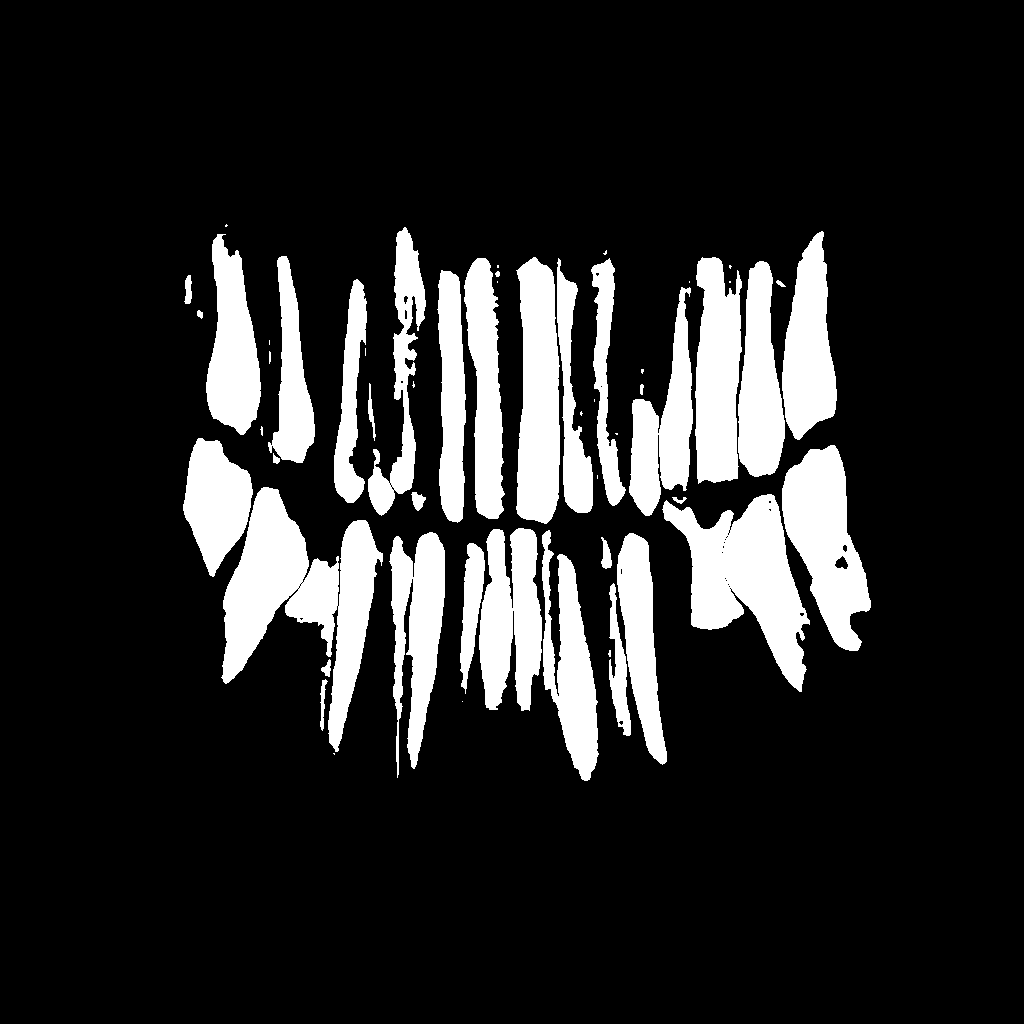

In [109]:
from segment_anything import SamPredictor
from google.colab.patches import cv2_imshow
loaded_model = torch.load(MODEL_SAVE_PATH)
IMAGE_NUMBER = 10
test_image = x_val[IMAGE_NUMBER]
test_image_yolo = x_val_yolo[IMAGE_NUMBER]

mask_predictor = SamPredictor(loaded_model)
mask_predictor.set_image(test_image)

results = yolo_model.predict(yolo_image)

boxes = results[0].boxes.xywhn
boxes = torch.Tensor.cpu(boxes)
box_list = []
for box in boxes:
  x1, y1, x2, y2 = get_fixed_coordinates(box,test_image)
  box_list.append([x1, y1, x2, y2])
boxes = np.array(box_list)

input_boxes = torch.tensor(boxes, device=mask_predictor.device)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_boxes, test_image.shape[:2])
masks, iou_predictions, low_res_masks = mask_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True
)
print("masks, boxes",masks.shape,transformed_boxes.shape)
full_mask = np.zeros((1024,1024))
for mask in masks:

  mask = torch.Tensor.cpu(mask).numpy()
  mask = mask[2,:,:]
  mask = mask*255
  mask = mask.astype(np.uint8)
  full_mask += mask
cv2_imshow(full_mask)


(1300, 3100, 3) uint8 255

0: 288x640 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


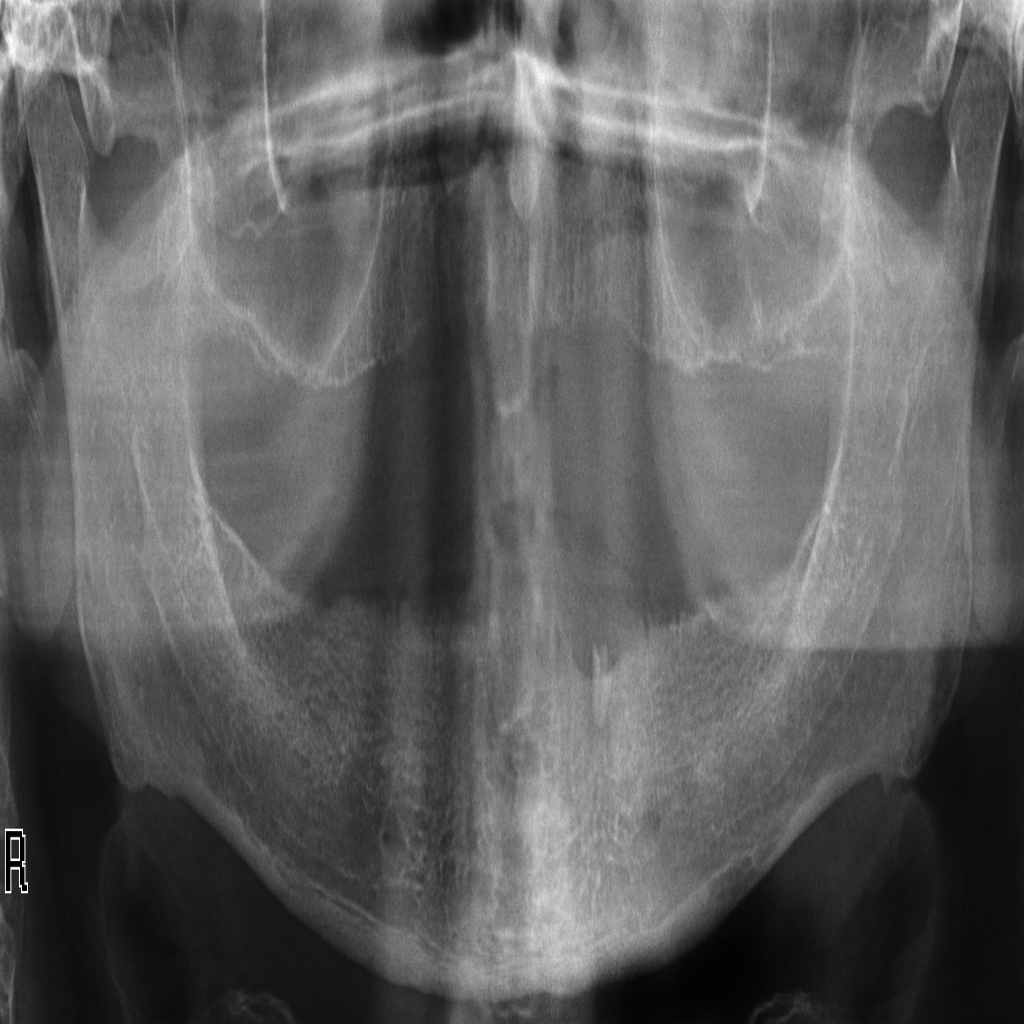

In [90]:
from ultralytics import YOLO
import torch
import numpy as np
import matplotlib.pyplot as plt
yolo_model = YOLO("/content/drive/MyDrive/DentalImages/TrainingCheckpoints/best_yolov8.pt")

image = x_train_yolo[4]

print(image.shape, image.dtype, np.max(image))


results = yolo_model.predict(image, conf=0.5)
boxes = results[0].boxes.xywhn
boxes = torch.Tensor.cpu(boxes)
image = cv2.resize(image,(1024,1024))
for box in boxes:
  x_center = box[0].numpy()
  y_center = box[1].numpy()
  width = box[2].numpy()
  height = box[3].numpy()

  x_center *= image.shape[1]
  y_center *= image.shape[0]
  width *= image.shape[1]
  height *= image.shape[0]

  x1 = int(x_center - width / 2)
  y1 = int(y_center - height / 2)
  x2 = int(x_center + width / 2)
  y2 = int(y_center + height / 2)


  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2_imshow(image)

In [23]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/DentalImages/TrainingCheckpoints/best_yolov8.pt conf=0.50 source='/content/data/Images/1.png'

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/data/Images/1.png: 288x640 25 tooths, 90.6ms
Speed: 3.6ms preprocess, 90.6ms inference, 530.0ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict
